In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('E:\Facial_Recognition\Facial-Recognition'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

E:\Facial_Recognition\Facial-Recognition\facenet_keras.h5
E:\Facial_Recognition\Facial-Recognition\haarcascade_frontalface_default.xml
E:\Facial_Recognition\Facial-Recognition\test.csv
E:\Facial_Recognition\Facial-Recognition\train.csv
E:\Facial_Recognition\Facial-Recognition\Untitled.ipynb
E:\Facial_Recognition\Facial-Recognition\.git\COMMIT_EDITMSG
E:\Facial_Recognition\Facial-Recognition\.git\config
E:\Facial_Recognition\Facial-Recognition\.git\description
E:\Facial_Recognition\Facial-Recognition\.git\HEAD
E:\Facial_Recognition\Facial-Recognition\.git\index
E:\Facial_Recognition\Facial-Recognition\.git\packed-refs
E:\Facial_Recognition\Facial-Recognition\.git\hooks\applypatch-msg.sample
E:\Facial_Recognition\Facial-Recognition\.git\hooks\commit-msg.sample
E:\Facial_Recognition\Facial-Recognition\.git\hooks\fsmonitor-watchman.sample
E:\Facial_Recognition\Facial-Recognition\.git\hooks\post-update.sample
E:\Facial_Recognition\Facial-Recognition\.git\hooks\pre-applypatch.sample
E:\Facia

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [2]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from PIL import Image
from skimage import exposure
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import keras_tuner
from keras import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Activation,Dropout,BatchNormalization,InputLayer
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

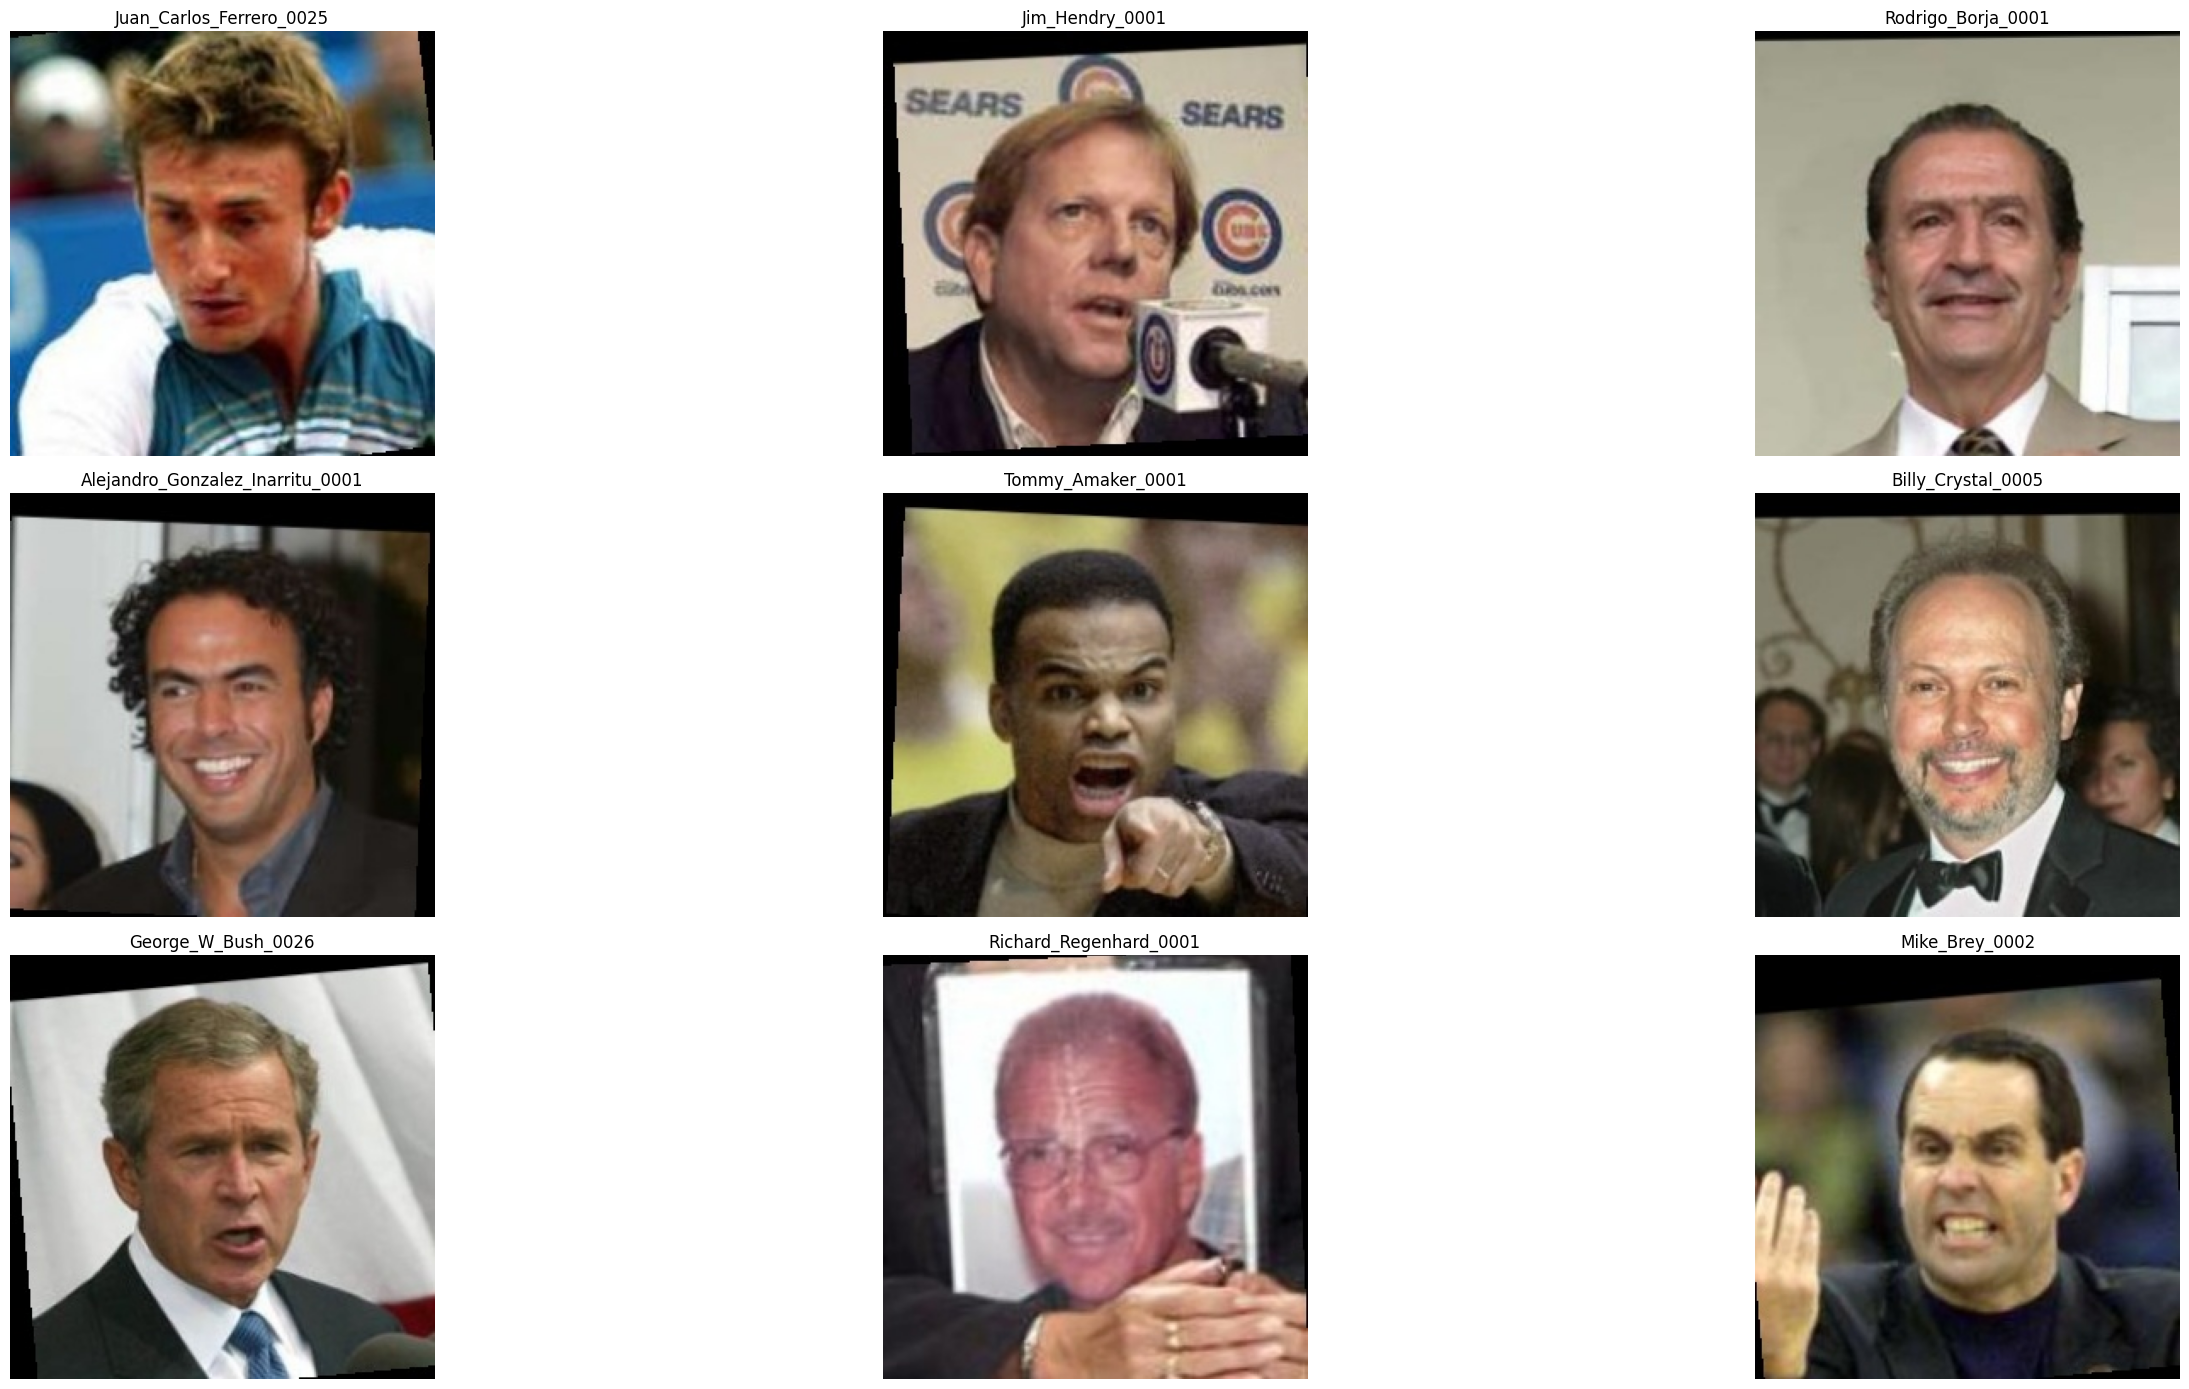

In [3]:
faces_path = 'E:\Facial_Recognition\Facial-Recognition\Faces'

image_files = [os.path.join(faces_path, filename) for filename in os.listdir(faces_path)]

num_samples = 9  # You want to plot 9 images

selected_images = random.sample(image_files, num_samples)

# Create subplots for displaying images
fig, axes = plt.subplots(3, 3, figsize=(30, 14))

# Display each selected image with the face name as label
for i, image_path in enumerate(selected_images):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.axis('off')  # Hide axis
    face_name = os.path.basename(image_path).split('.')[0]  # Extract face name from file name
    ax.set_title(face_name, fontsize=12)  # Set title as face name

# Show the images 
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()



In [8]:
import cv2
import os
import yaml

# Path to the directory containing the images
directory = 'E:\Facial_Recognition\Facial-Recognition\Faces'

# Path to the pre-trained Haar cascade classifier for face detection
cascade_path = "haarcascade_frontalface_default.xml"

# Check if the Haar cascade file exists
if not os.path.exists(cascade_path):
    raise FileNotFoundError(f"Haar cascade file not found at {cascade_path}")

# Load the Haar cascade classifier
face_cascade = cv2.CascadeClassifier(cascade_path)

def annotate_images(directory):
    # Create directories to save annotated images and labels
    output_dir = "working/annotated_images"
    label_dir = "working/labels"
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

    # Initialize list to store annotations
    annotations = []

    # Loop through each image in the directory
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        # Read the image
        img = cv2.imread(img_path)
        # Convert the image to grayscale for face detection
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Detect faces in the image
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        # Draw bounding boxes around the detected faces
        for (x, y, w, h) in faces:
            # Draw bounding box
            cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
            # Write label above the bounding box (here, the label is the filename without extension)
            label = os.path.splitext(filename)[0].replace("_", " ")
            cv2.putText(img, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
            # Save the annotated image
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, img)
            # Save label to corresponding label file
            label_path = os.path.join(label_dir, filename.replace(".jpg", ".txt"))
            with open(label_path, "w") as label_file:
                label_file.write(label)

            # Add annotation to list
            annotations.append({"image_path": output_path, "label": label})
    
    return annotations

# Call the function to annotate images in the directory
annotations = annotate_images(directory)

# Write annotations to YAML file
output_yaml_path = "working/dataset.yaml"
with open(output_yaml_path, "w") as yaml_file:
    yaml.dump(annotations, yaml_file)

print("YAML file saved successfully.")


YAML file saved successfully.


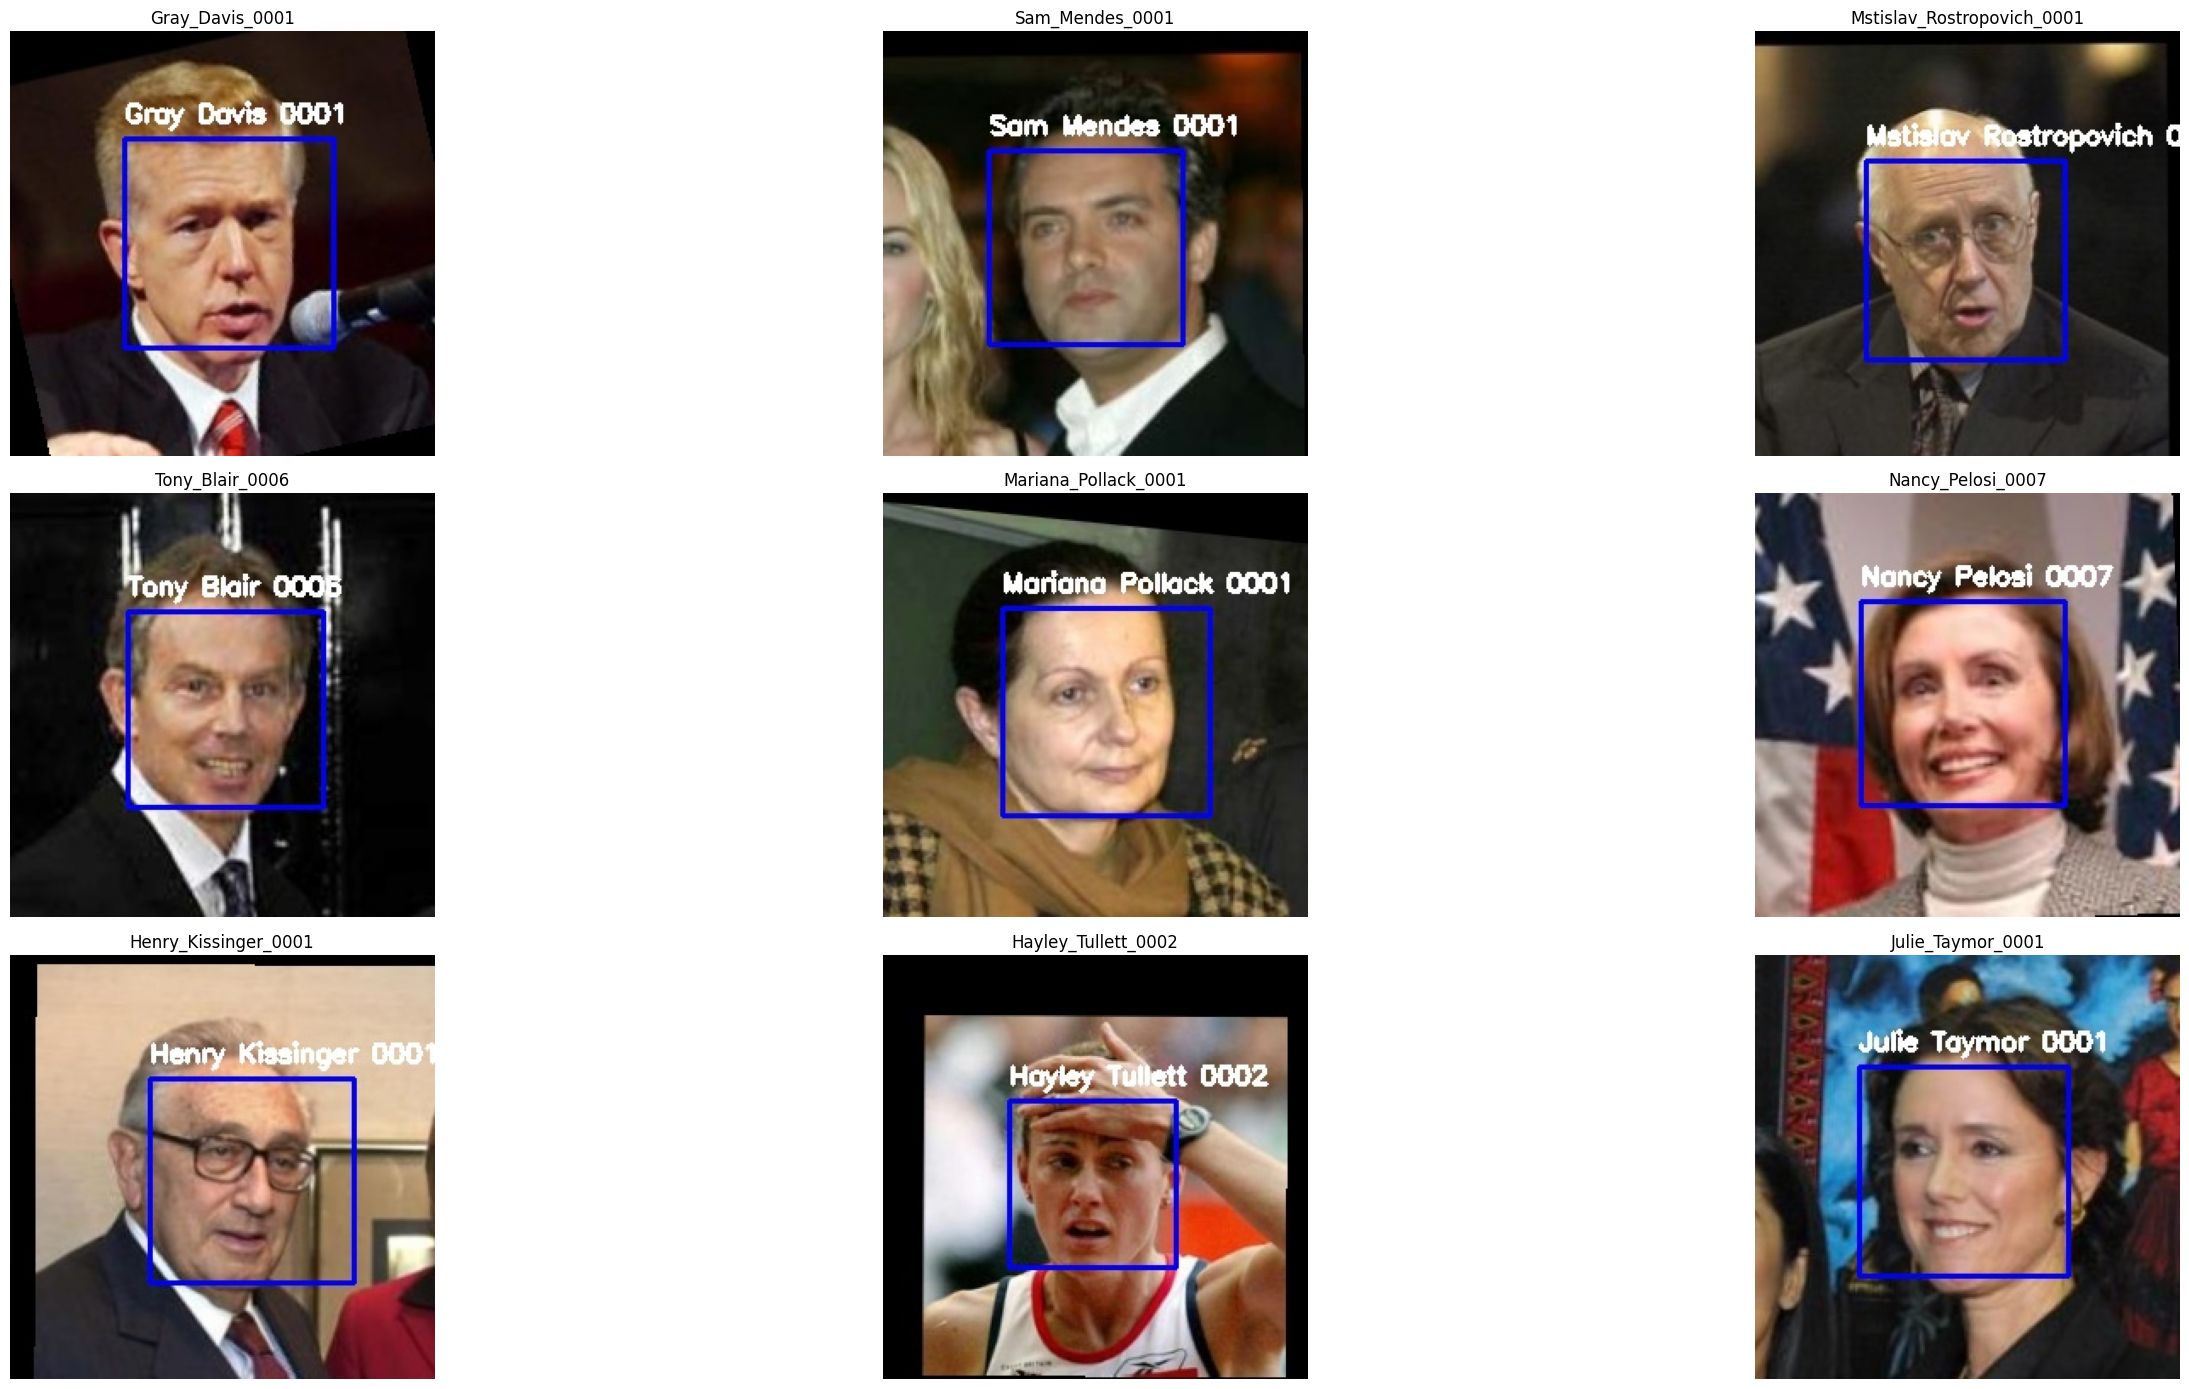

In [4]:
faces_path = 'working/annotated_images'

image_files = [os.path.join(faces_path, filename) for filename in os.listdir(faces_path)]

num_samples = 9  # You want to plot 9 images

selected_images = random.sample(image_files, num_samples)

# Create subplots for displaying images
fig, axes = plt.subplots(3, 3, figsize=(30, 14))

# Display each selected image with the face name as label
for i, image_path in enumerate(selected_images):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.axis('off')  # Hide axis
    face_name = os.path.basename(image_path).split('.')[0]  # Extract face name from file name
    ax.set_title(face_name, fontsize=12)  # Set title as face name

# Show the images 
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [5]:
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import joblib
from keras_facenet import FaceNet


In [12]:
pip install keras-facenet

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.3 MB 640.0 kB/s eta 0:00:04
   -- ------------------------------------- 0.2/2.3 MB 2.4 MB/s eta 0:00:01
   ---------------- ----------------------- 0.9/2.3 MB 9.7 MB/s eta 0:00:01
   ---------------------------- ----------- 1.6/2.3 MB 13.0 MB/s eta 0:00:01
   ------------------------------- -------- 1.8/2.3 MB 11.5 MB/s eta 0:00:01
   -------------------------------- ------- 1.8/2.3 MB 10.6 MB/s eta 0:00:01
   ----------------------------------- ---- 2.0/2.3 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 8.5 MB/s eta 0:00:00
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10387 sha256=cf15f1a3a3af4c695ed6499f63c042e6d75e82b1c2815fc74fdfb57d70e717cb
  Stored in directory: c:\users\user\appdata\local\p

In [6]:
embedder = FaceNet()